# 1. Data loading and preprocessing

In [168]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


In [140]:
# Read the Parquet file into a DataFrame
df = pd.read_parquet('all_data_fixed_quarter_dates.parquet')

In [141]:
df = df[df['Rating'].notnull()]

df.dropna(axis=0,subset=df.columns[160], inplace=True)

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df.dropna(axis=0, subset=df.columns[31:157],inplace=True)

# 2. Model

## Task1: Credit Rating prediction 

### model 1
First, we only use the Altman_Z as covariate

In [142]:
X = df["Altman_Z"].values.reshape(-1, 1)

Y = df['Rating']
custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}
Y_encoded = Y.map(custom_mapping)


X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000,multi_class='multinomial',penalty="l2",class_weight='balanced') 

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate the share of the majority class for each prediction
majority_class_share_baseline = y_test.value_counts(normalize=True).max()
print("majority baseline:", majority_class_share_baseline)

Accuracy: 0.18618365627632688
F1 Score: 0.21929095897828313
majority baseline: 0.3209772535804549


# model 2
Then we add all numerical features

In [143]:
X = df.iloc[:,31:157].select_dtypes(include=['int64', 'float64'])

X.drop(columns=["Ratio_A","Ratio_B","Ratio_C","Ratio_D","Ratio_E"],inplace=True)

Y = df['Rating']
custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}
Y_encoded = Y.map(custom_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000,multi_class='multinomial',class_weight='balanced') 

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate the share of the majority class for each prediction
majority_class_share_baseline = y_test.value_counts(normalize=True).max()
print("majority baseline:", majority_class_share_baseline)

Accuracy: 0.5214827295703454
F1 Score: 0.5204718927035893
majority baseline: 0.3209772535804549


In [144]:
for column_name in X.columns:
    print(column_name)

cashAndCashEquivalents
shortTermInvestments
cashAndShortTermInvestments
netReceivables
inventory
otherCurrentAssets
totalCurrentAssets
propertyPlantEquipmentNet
goodwill
intangibleAssets
goodwillAndIntangibleAssets
longTermInvestments
taxAssets
otherNonCurrentAssets
totalNonCurrentAssets
otherAssets
totalAssets
accountPayables
shortTermDebt
taxPayables
deferredRevenue
otherCurrentLiabilities
totalCurrentLiabilities
longTermDebt
deferredRevenueNonCurrent
deferredTaxLiabilitiesNonCurrent
otherNonCurrentLiabilities
totalNonCurrentLiabilities
otherLiabilities
capitalLeaseObligations
totalLiabilities
preferredStock
commonStock
retainedEarnings
accumulatedOtherComprehensiveIncomeLoss
othertotalStockholdersEquity
totalStockholdersEquity
totalEquity
totalLiabilitiesAndStockholdersEquity
minorityInterest
totalLiabilitiesAndTotalEquity
totalInvestments
totalDebt
netDebt
cik_cash_flow_statement
netIncome
depreciationAndAmortization
deferredIncomeTax
stockBasedCompensation
changeInWorkingCapital
a

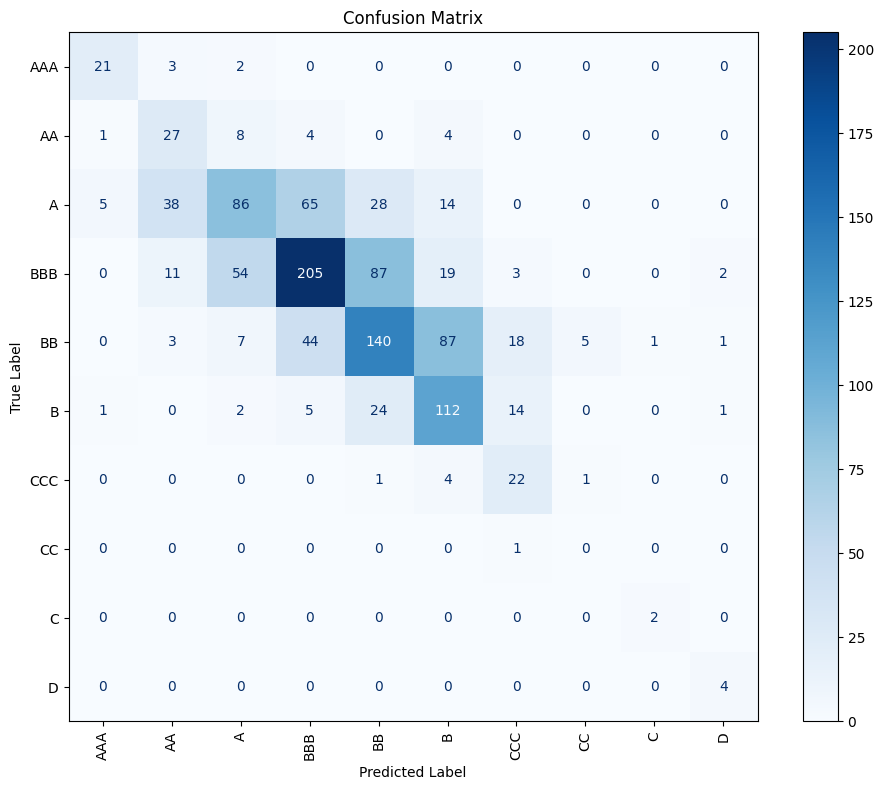

In [145]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.arange(0,10))

# Confusion Matrix Display
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=custom_mapping.keys())

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
cm_display.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

### model 3
We then add the L1 regularization to reduce overfitting and do varible selection

In [151]:
X = df.iloc[:,31:157].select_dtypes(include=['int64', 'float64'])
X.drop(columns=["Ratio_A","Ratio_B","Ratio_C","Ratio_D","Ratio_E"],inplace=True)
Y = df['Rating']
custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}
Y_encoded = Y.map(custom_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=5000,multi_class='multinomial',penalty="l1",C=1,solver="saga",class_weight='balanced') 

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate the share of the majority class for each prediction
majority_class_share_baseline = y_test.value_counts(normalize=True).max()
print("majority baseline:", majority_class_share_baseline)

Accuracy: 0.493681550126369
F1 Score: 0.4987766777652801
majority baseline: 0.3209772535804549


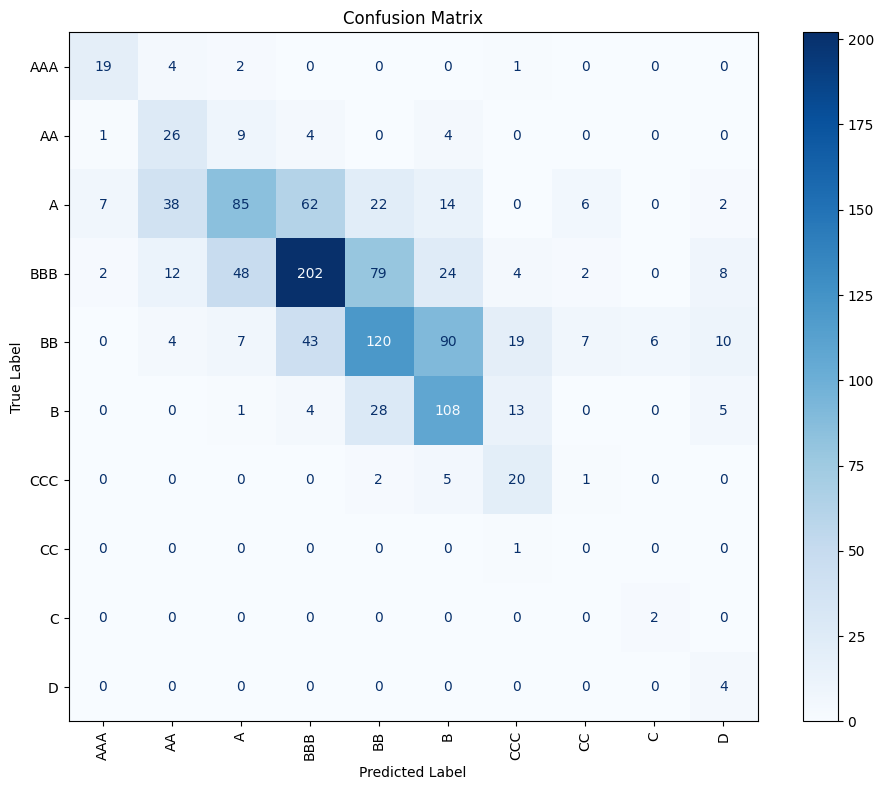

In [147]:
conf_matrix = confusion_matrix(y_test, y_pred, labels=np.arange(0,10))

# Confusion Matrix Display
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=custom_mapping.keys())

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
cm_display.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()




## Task2: Credit Rating Changing Prediction 

# model 1
We add all numerical variables and add L1 regularization

In [148]:
X = df.iloc[:,31:157].select_dtypes(include=['int64', 'float64'])
X.drop(columns=["Ratio_A","Ratio_B","Ratio_C","Ratio_D","Ratio_E"],inplace=True)

Y = df['Change Since Last Fixed Quarter Date']
Y = Y.map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'})

custom_mapping = {'downgrade': 0, 'no change': 1, 'upgrade': 2}
Y_encoded = Y.map(custom_mapping)

X_train, X_test, y_train, y_test = train_test_split(X, Y_encoded , test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#model = LogisticRegression(max_iter=1000,multi_class='multinomial', solver='lbfgs') 
model = LogisticRegression(max_iter=5000,multi_class='multinomial',penalty="l1",solver="saga") 

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)

# Calculate the share of the majority class for each prediction
majority_class_share_baseline = y_test.value_counts(normalize=True).max()
print("majority baseline:", majority_class_share_baseline)

Accuracy: 0.9359730412805392
F1 Score: 0.9112151131429932
majority baseline: 0.941027801179444


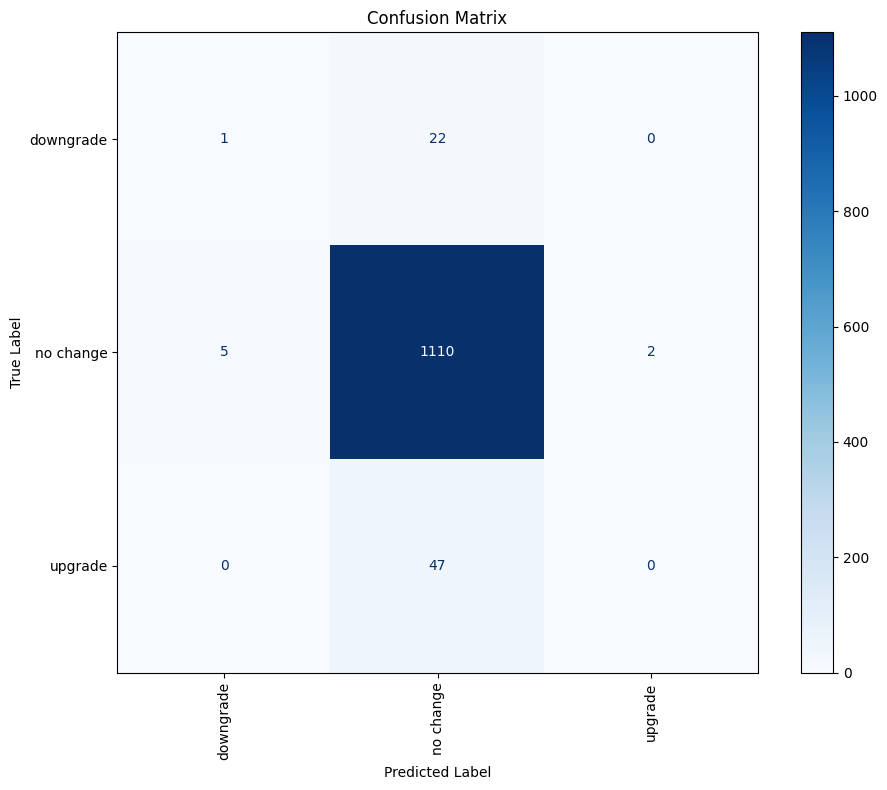

In [149]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion Matrix Display
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=custom_mapping.keys())

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
cm_display.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Updated

# One function for training (add one-hot categorical features)

In [173]:
def train_and_evaluate_model(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, test_size=0.2, random_state=42,
                             penalty='l1', class_weight=None, max_iter=5000, solver="saga"):
    """
    Trains and evaluates a logistic regression model.

    Parameters:
    - df: DataFrame containing the dataset.
    - numeric_feature_columns: list of numeric columns to be used as features.
    - cat_feature_columns: list of categorical columns to be used as features.
    - target_column: column to be used as target.
    - custom_mapping: dictionary to encode the target variable.
    - test_size: proportion of the dataset to include in the test split.
    - random_state: controls the shuffling applied to the data before applying the split.
    - penalty: regularization type ('l1' or 'l2').
    - class_weight: weights associated with classes. If not given, all classes are supposed to have weight one.
    - max_iter: maximum number of iterations taken for the solvers to converge.
    - solver: optimizer choice

    Returns:
    A dictionary with accuracy, F1 score, and majority class baseline.
    """
    # Selecting features and target, and encoding target
    numeric_X = df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
    cat_X = df[cat_feature_columns]
    X = pd.concat([numeric_X, cat_X], axis=1)
    Y = df[target_column].map(custom_mapping)
    
    
    # Splitting data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    # Preprocessing
    numeric_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_feature_columns),
            ('cat', cat_transformer, cat_feature_columns)
        ])

    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    
    # Model training
    model = LogisticRegression(penalty=penalty, max_iter=max_iter, class_weight=class_weight, solver='saga', multi_class='multinomial')
    model.fit(X_train_scaled, y_train)
    
    # Model prediction and evaluation
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    majority_class_share_baseline = y_test.value_counts(normalize=True).max()
    
    return {'accuracy': accuracy, 'f1_score': f1, 'majority_baseline': majority_class_share_baseline}



In [174]:
numeric_feature_columns = ["Altman_Z"]
cat_feature_columns = ['Sector']
target_column = "Rating"
custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping)

{'accuracy': 0.4060657118786858,
 'f1_score': 0.38184072576541944,
 'majority_baseline': 0.3209772535804549}